In [29]:
import pandas as pd # conda install pandas
import numpy as np
import matplotlib.pyplot as plt # conda install matplotlib
import seaborn as sns # conda install seaborn
from sklearn.model_selection import train_test_split # conda install scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Carga de datos y vista general

In [31]:
df = pd.read_csv("business/2024/6/12/data-2024-06-12.csv")

In [32]:
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,price,processed_date
0,6901257,5.010635,Apartment,Entire home/apt,"{Wireless Internet, Air conditioning, Kitchen,...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Brooklyn Heights,2,100.0,11201,1.0,1.0,150,2024-06-12
1,6304928,5.129899,Apartment,Entire home/apt,"{Wireless Internet, Air conditioning, Kitchen,...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0,169,2024-06-12
2,13418779,6.620073,House,Entire home/apt,"{TV, Cable TV, Internet, Wireless Internet, Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Lower Haight,0,NaN,94117,2.0,2.0,750,2024-06-12
3,12422935,4.442651,Apartment,Private room,"{TV, Wireless Internet, Heating, Smoke detecto...",2,1.0,Real Bed,strict,True,...,37.753164,-122.429526,Noe Valley,3,100.0,94131,1.0,1.0,85,2024-06-12
4,11825529,4.418841,Apartment,Entire home/apt,"{TV, Internet, Wireless Internet, Air conditio...",3,1.0,Real Bed,moderate,True,...,33.980454,-118.462821,NaN,15,97.0,90292,1.0,1.0,82,2024-06-12


## Creación de columnas correspondientes a *amenities*

In [33]:
amenities = []
def listar(x,amenities):
    amenities += (x.replace("{","").replace("}","").replace("\"","").split(","))
    return x
df.amenities.apply(lambda x: listar(x, amenities))
amenities = [amenity[1:] if len(amenity) and amenity[0] == " " else amenity for amenity in amenities]
amenities = list(set(amenities))
if "" in amenities: amenities.remove("")
sorted(amenities)

['24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bath towel',
 'Bathtub',
 'Bathtub with shower chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Body soap',
 'Breakfast',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Doorman Entry',
 'Dryer',
 'EV charger',
 'Elevator',
 'Elevator in building',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm matress',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower & toilet',
 'Flat',
 'Flat smooth pathway to front do

In [8]:
df = pd.concat([df, pd.DataFrame(columns=amenities)], axis=1)

In [9]:
for column in amenities:
    df[column] = df.amenities.apply(lambda x: 1 if column in x else 0)
df.drop(["amenities"], axis=1, inplace=True)

In [10]:
df.sample(5)

,id,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,Window guards,Coffee maker,Babysitter recommendations,Bathtub with shower chair,Heating,Cable TV,Pack ’n Play/travel crib,Disabled parking spot,Changing table,Extra pillows and blankets
24157,15095869,5.521461,House,Private room,1,1.0,Real Bed,strict,True,SF,...,0,0,0,0,1,1,0,0,0,0
17118,10090585,5.220356,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,Boston,...,0,0,0,0,1,0,0,0,0,0
29397,9523431,5.393628,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,SF,...,0,0,0,0,1,1,0,0,0,0
11995,14768657,5.241747,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,NYC,...,0,0,0,0,1,1,0,0,0,0
16921,6196265,4.317488,Apartment,Private room,2,1.0,Real Bed,moderate,True,NYC,...,0,0,0,0,1,0,0,0,0,0


Hay columnas de amenities que hacen referencia a lo mismo:
* *Firm matress* y *Firm mattress*,
* *Smart lock* y *Smartlock*,
* *Wide clearance to shower & toilet* y *Wide clearance to shower and toilet*.
Se unifican dichas columnas.

In [11]:
df["Firm mattress"] = df["Firm mattress"] + df["Firm matress"]
df["Firm mattress"] = df["Firm mattress"].apply(lambda x: 1 if x > 0 else 0)
df["Smart lock"] = df["Smart lock"] + df["Smartlock"]
df["Smart lock"] = df["Smart lock"].apply(lambda x: 1 if x > 0 else 0)
df["Wide clearance to shower and toilet"] = df["Wide clearance to shower and toilet"] + df["Wide clearance to shower & toilet"]
df["Wide clearance to shower and toilet"] = df["Wide clearance to shower and toilet"].apply(lambda x: 1 if x > 0 else 0)
df.drop(["Firm matress", "Smartlock", "Wide clearance to shower & toilet"], axis=1, inplace=True)

# Creación de los conjuntos train y test

In [12]:
train, test = train_test_split(df, test_size=0.2, random_state=0)

In [13]:
print(f"Tamaño del train set: {train.shape}.")
print(f"Tamaño del test set: {test.shape}.")

Tamaño del train set: (41873, 153).
Tamaño del test set: (10469, 153).


# Limpieza de datos

In [16]:
print("Columnas numéricas y categóricas sin tener en cuenta las de amenities (son numéricas).")
print(f"Columnas numéricas: {list(train.loc[:,:'beds'].select_dtypes(include=['number', 'datetime']).columns)}")
print(f"Columnas categóricas: {list(train.loc[:,:'beds'].select_dtypes(exclude=['number','datetime']).columns)}")

Columnas numéricas y categóricas sin tener en cuenta las de amenities (son numéricas).
Columnas numéricas: ['id', 'log_price', 'accommodates', 'bathrooms', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'zipcode', 'bedrooms', 'beds']
Columnas categóricas: ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'first_review', 'host_has_profile_pic', 'host_identity_verified', 'host_response_rate', 'host_since', 'instant_bookable', 'last_review', 'neighbourhood']


Hay algunas columnas cuyo tipo no se corresponde. Se cambian los tipos:

In [17]:
train["first_review"] = pd.to_datetime(train["first_review"])
train["host_since"] = pd.to_datetime(train["host_since"])
train["last_review"] = pd.to_datetime(train["last_review"])
train["processed_date"] = pd.to_datetime(train["processed_date"])
train["host_response_rate"] = train["host_response_rate"].apply(lambda x: float(x[:-1]) if type(x) == str else np.nan)
train["zipcode"] = train.zipcode.apply(lambda x: str(int(float(x))).zfill(5))
test["first_review"] = pd.to_datetime(test["first_review"])
test["host_since"] = pd.to_datetime(test["host_since"])
test["last_review"] = pd.to_datetime(test["last_review"])
test["processed_date"] = pd.to_datetime(test["processed_date"])
test["host_response_rate"] = test["host_response_rate"].apply(lambda x: float(x[:-1]) if type(x) == str else np.nan)
test["zipcode"] = test.zipcode.apply(lambda x: str(int(float(x))).zfill(5))

In [18]:
print("Columnas numéricas y categóricas sin tener en cuenta las de amenities (son numéricas).")
columnas_numericas = list(train.loc[:,:"beds"].select_dtypes(include=["number","datetime"]).columns)
columnas_categoricas = list(train.loc[:,:"beds"].select_dtypes(exclude=["number","datetime"]).columns)
print(f"Columnas numéricas: {columnas_numericas}")
print(f"Columnas categóricas: {columnas_categoricas}")

Columnas numéricas y categóricas sin tener en cuenta las de amenities (son numéricas).
Columnas numéricas: ['id', 'log_price', 'accommodates', 'bathrooms', 'first_review', 'host_response_rate', 'host_since', 'last_review', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds']
Columnas categóricas: ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'neighbourhood', 'zipcode']


## Tratamiento de nulos

In [19]:
# Columnas con nulos:
print(f"Columnas con nulos en el train set: {train.columns[train.isna().any()].tolist()}")
print(f"Columnas con nulos en el test set: {test.columns[test.isna().any()].tolist()}")

Columnas con nulos en el train set: ['bathrooms', 'first_review', 'host_has_profile_pic', 'host_identity_verified', 'host_response_rate', 'host_since', 'last_review', 'neighbourhood', 'review_scores_rating', 'bedrooms', 'beds']
Columnas con nulos en el test set: ['bathrooms', 'first_review', 'host_has_profile_pic', 'host_identity_verified', 'host_response_rate', 'host_since', 'last_review', 'neighbourhood', 'review_scores_rating', 'bedrooms', 'beds']


In [20]:
# Cantidad de nulos por columna.
train[train.columns[train.isna().any()]].isna().sum()

bathrooms                    98
first_review               9278
host_has_profile_pic        111
host_identity_verified      111
host_response_rate        11846
host_since                  111
last_review                9258
neighbourhood              3435
review_scores_rating       9806
bedrooms                     55
beds                         70
dtype: int64

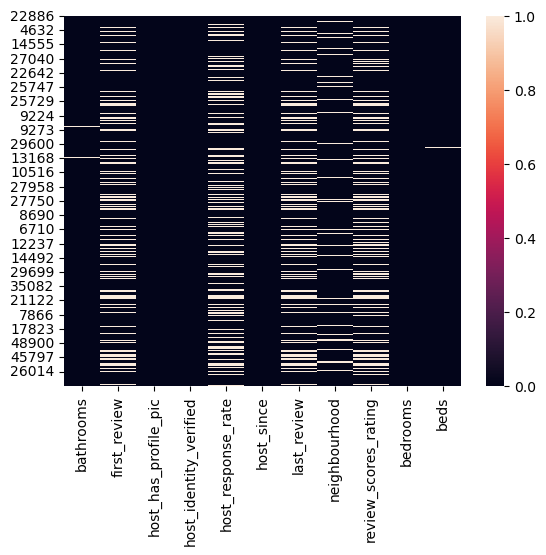

In [21]:
sns.heatmap(train[train.columns[train.isna().any()].tolist()].isna())
plt.show()

In [22]:
# Se imputan medianas y modas a las columnas en las que hay nulos:
train[columnas_numericas] = train[columnas_numericas].fillna(train[columnas_numericas].median())
test[columnas_numericas] = test[columnas_numericas].fillna(test[columnas_numericas].median())

In [23]:
train[columnas_categoricas] = train[columnas_categoricas].fillna(train[columnas_categoricas].mode())
test[columnas_categoricas] = test[columnas_categoricas].fillna(test[columnas_categoricas].mode())

<mark>por alguna razón no he conseguido deshacerme de todos los nulos todavía</mark>

In [26]:
train[train.columns[train.isna().any()]].isna().sum()
test[test.columns[test.isna().any()]].isna().sum()

Series([], dtype: float64)

In [25]:
train = train.dropna()
test = test.dropna()


## Eliminacion de columnas

### Cosas a hacer (bastante a grandes rasgos, tampoco lo he mirado a fondo):
* eliminar la columna id (identifica, no aporta nada)
* one hot encoding *property_type*
* one hot encoding *room_type*
* eliminar la columna amenities (ya he creado las columnas correspondientes)
* convertir a tipo entero bathrooms
* one hot encoding a *bed_type*
* one hot encoding a *cancellation_policy*
* convertir a 0 (False) y 1 (True) *cleaning_fee*, *host_has_profile_pic*, *host_identity_verified*, *instant_bookable*
* ¿convertir a entero *host_response_rate*? (??????)
* *neighbourhood* -> son 600 valores posibles, hacerle un one hot encoding me parece una locura, yo la eliminaría
* ¿convertir a enter *review_scores_rating*?
* *zipcode* -> son 632 valores posibles, hacerle un one hot encoding me parece una locura, yo la eliminaría; si queremos hacer algo con esa columna, habría que *volver a* añadir los ceros debidos a la izquierda, aunque en todo caso se aplicaría one hot encoding así que no afectaría no añadir los ceros y aún así usar la columna
* ¿convertir a entero *bedrooms* y *beds*?


primero: tratamiento de nulos

tramiento de duplicados

sacar un histograma

buscar relaciones, matriz de correlación

relaciones entre columnas

sacar gráficos